 ![logo][gfzlogo]
 
 #   ENHANS -   Exposure modelling Workshop   -  May 2017
 
 ---
 
 
 ## 2.1 - Prioritization of the Field Survey
 
 
 ---

 


[gfzlogo]:gfz_logo2.jpg

## language: R

### first: Load packages

In [1]:
require(rgdal)
#require(ggplot2)
require(sp)
require(spatstat)
#require(maptools)
require(raster)


outpath = "/media/sf_workshop_material/activities/2-survey_design/exdata_peru/data0/tmp_proc"

Loading required package: rgdal
Loading required package: sp
rgdal: version: 1.2-7, (SVN revision 660)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 1.11.3, released 2015/09/16
 Path to GDAL shared files: /usr/share/gdal/1.11
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.2-4 
Loading required package: spatstat
Loading required package: nlme
Loading required package: rpart

spatstat 1.51-0       (nickname: ‘Poetic Licence’) 
For an introduction to spatstat, type ‘beginner’ 

Loading required package: raster

Attaching package: ‘raster’

The following objects are masked from ‘package:spatstat’:

    area, rotate, shift

The following object is masked from ‘package:nlme’:

    getData



## define some basic functions to implement focus maps

In [2]:
#load a set of raster layers from a list of paths
#reproject them to the WGS84 lat lon CRS
#resample them according to the first layer
#returns a list of rasters (or a stack?)
LoadRasterLayers<-function(layers_paths,repro=FALSE,resamp=FALSE,flip=FALSE)
{
	#bulk load all layers in a list
	input.ras <- lapply(layers_paths,raster)
	#flip vertically to compensate a problem of the loader
	if (flip) input.ras<-lapply(input.ras,FUN=function(x){flip(x,'y')})
	
	if (repro)
	{
		# reproject them into a lon-lat 
		f<-function(x)
		{
			if (! isLonLat(x))
			{
			crs<-"+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"
			print(paste("reprojecting layer from ",projection(x)," to lat-lon (WGS84)",sep=''))
			return(projectRaster(x,crs=crs))
			}
			else return(x)
		}
		out<-lapply(input.ras,FUN=f)
		if (resamp) return(ResampleLayers(out)) 
		else return(out)
	}
	else if (resamp) return(ResampleLayers(input.ras))
	else return(input.ras)
}
        

ResampleLayers<-function(rasters,ref_index=NULL)
{
	ref<-1
	f<-function(x)
	{
		print(paste("resampling ",x@data@names,sep=''))
		resample(x,rasters[[ref]])
	}
	c(rasters[ref],lapply(rasters[-ref],FUN=f))
}

#transforms a vector (shapefile) into a raster
#needs a SpatialPolygonsDataFrame object
#and the data attribute to be rasterized
#returns a raster
Vec2Raster<-function(vec,ras_attr,res)
{
	#generate a raster with the right extent
	r <- raster(extent(vec))
	#set resolution
	res(r)<-res
	#rasterize
    ras<-rasterize(vec,r,field=ras_attr)
	return(ras)
}

Vec2FocusMap<-function(vec,ras_attr_layers,weights)
{
	return(NULL)
}

#normalize a raster
#if norm_type="linear" perform contrast stretching
#if rejection bounds rej are not null, the relative quantiles
#are used as normalization values, to mitigate outliers
#returns a normalized raster
NormalizeLayer<-function(rast,norm_type="linear",rej=NULL)
{
	if (norm_type=="linear")
	{
		if (! is.null(rej))
		{
			if (rej[1]<0 | rej[2]>100 | rej[1]>= rej[2]) stop('error in the rejection bound')
			qq<-quantile(rast,prob=rej)
			min<-qq[1]
			max<-qq[2]
		}
		else
		{
			qq<-quantile(rast,prob=c(0,1))
			min<-qq[1]
			max<-qq[2]
		}
		if (max<1e-8) stop('upper normalization value < 1e-8 (almost zero)')
		
		rast[rast<min]<-min
		rast[rast>max]<-max
		out<-calc(rast,fun=function(x) {(x-min)/(max-min)})
		return(out)
	}
	else stop (paste("unknown normalization type: ",norm_type,sep=''))
}

#create a Focus Map from a stack / list of rasters
#requires a pooling function "linear" or "loglinear"
#and a vector of weigths
#returns a raster
FocusMap<-function(layers,pooling="loglinear",weigths)
{
	if (pooling=="loglinear")
	{
		out<-log(layers[[1]]+1e-5)*weigths[1]
		for (i in 2:length(layers))
		{
			out<-out+log(layers[[i]]+1e-5)*weigths[i]
		}
		return(exp(out))
	}
	else if (pooling=="linear")
	{
		out<-layers[[1]]*weigths[1]
		for (i in 2:length(layers))
		{
			out<-out+layers[[i]]*weigths[i]
		}
		return(out)
	}
	else stop(paste("unknown pooling type: ",pooling,sep=''))
}


# somple mosaicing of rasters with same origin, resolution and projection
MosaicRasters<-function(paths)
{
	input.ras <- lapply(paths,raster)
	#TODO: check that they have same resolution and projection
	input.arg<-input.ras
	names(input.arg)<-NULL
	input.arg$fun<-max
	output.ras<-do.call(mosaic,input.arg)
	return(output.ras)
}

#generate inhomogeneous distribution of sampling point
#according to the input raster, as intensity of a 
#Poisson Point Process
#return a set of spatial points
SamplingPoints<-function(rast,coef)
{
	mbox<-bbox(rast)
	mat<-as.matrix(flip(rast,'y'))
	ndens<-as.im(mat*coef)
	Z<-rpoispp(ndens)
	#rescale the points on the raster extent
	x<-Z$x*((mbox[1,2]-mbox[1,1])/ndens$xrange[2])+mbox[1,1]
	y<-(Z$y)*((mbox[2,2]-mbox[2,1])/ndens$yrange[2])+mbox[2,1]
	return(SpatialPoints(cbind(x,y)))
}

SamplingPoints_n<-function(rast,npts,coef=0.1)
{
	mbox<-bbox(rast)
	mat<-as.matrix(flip(rast,'y'))
	ndens<-as.im(mat*coef)
	Z<-rpoispp(ndens)
	#rescale the points on the raster extent
	x<-Z$x*((mbox[1,2]-mbox[1,1])/ndens$xrange[2])+mbox[1,1]
	y<-(Z$y)*((mbox[2,2]-mbox[2,1])/ndens$yrange[2])+mbox[2,1]
    smp = SpatialPoints(cbind(x,y))
	return(sample(smp,npts,replace=FALSE))
}

# Input Data



##1. load a rasterized vector describing the integrated risk for the Lima districts 







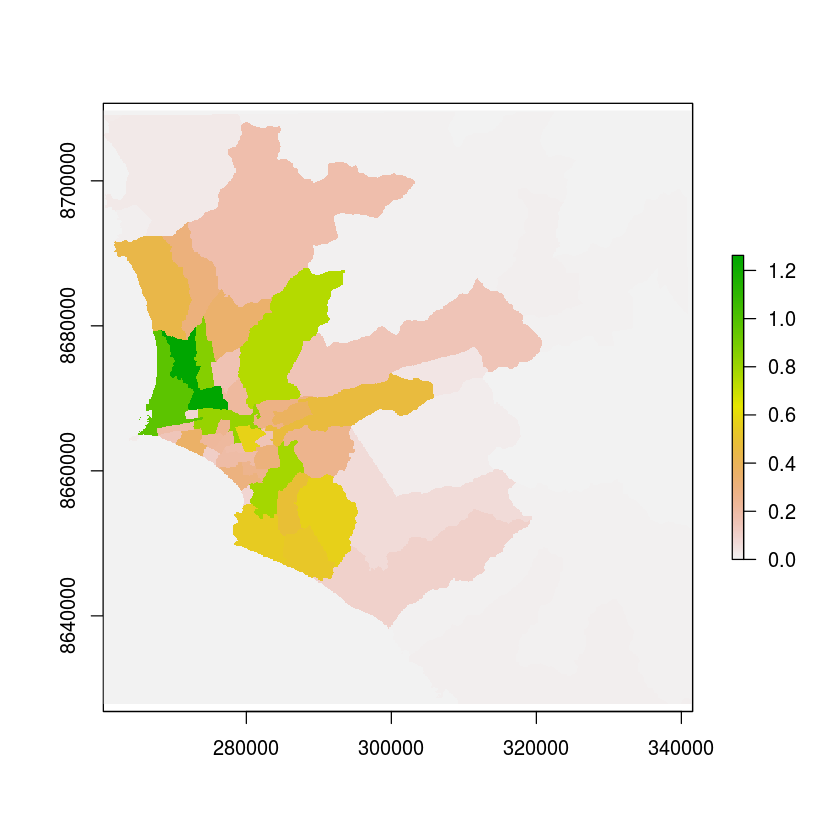

In [3]:
ras_intrisk_path<-"/media/sf_workshop_material/activities/2-survey_design/exdata_peru/data0/tmp_proc/vir_clipped"
ir_ras <- raster(ras_intrisk_path)
plot(ir_ras)

## 2. Load a raster describing the density of road nodes, as proxy of urbanization

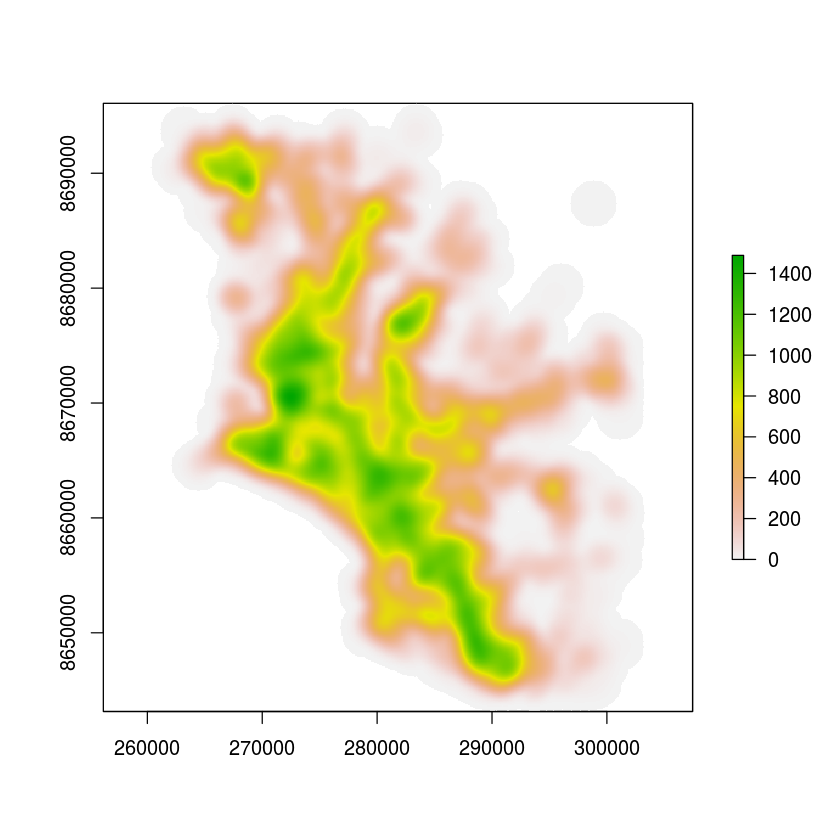

In [4]:
ras_roaddens_path<-"/media/sf_workshop_material/activities/2-survey_design/exdata_peru/data0/tmp_proc/dens7.tif"
roaddens_ras <- raster(ras_roaddens_path)
roaddens_ras <-flip(roaddens_ras,'y')
#roaddens_ras<-LoadRasterLayers(c(ras_roaddens_path),repro=FALSE,resamp=FALSE,flip=TRUE)
plot(roaddens_ras)

## Normalize the two input layers and resample to a common spatial resolution

In [5]:
l_ras<- c(roaddens_ras,ir_ras)
ras_n<-lapply(l_ras,NormalizeLayer)
#plot(ras_n[[1]])
ras_nr<-ResampleLayers(ras_n)


[1] "resampling "


## Compute the focus map as a log-linear pooling of te two input vectors with a specific set of weights

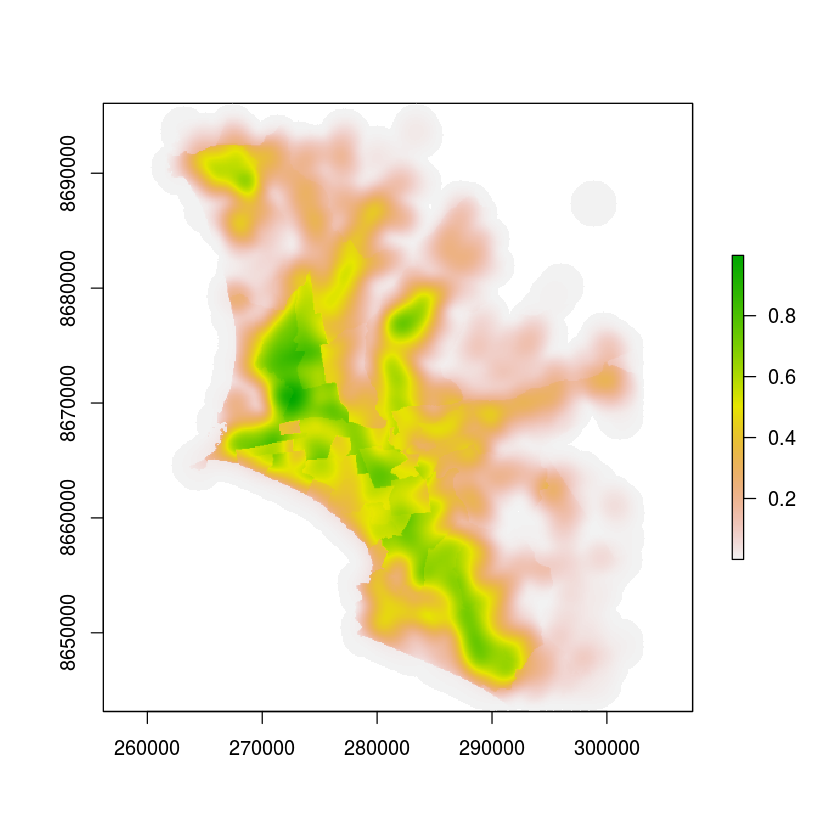

In [6]:
fm<-FocusMap(ras_nr,pooling="loglinear",weigths=c(.8,.2))
plot(fm)

# save focus map
file<-sprintf("%s%s",outpath,'Focus_map.tif')
writeRaster(fm,filename=file,format='GTiff',overwrite=TRUE)


## Use the resulting focus map as a 2D inhomogeneous density function to generate a set of sampling points

###Now you can try to change the settings and see how the sampling set changes

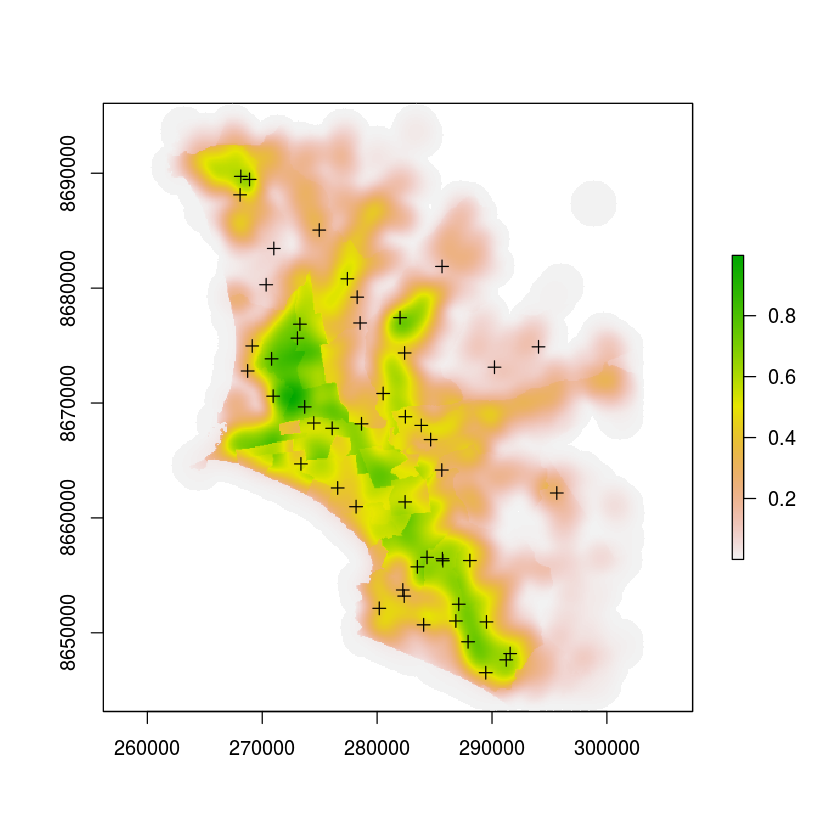

In [7]:
smp <- SamplingPoints_n(fm,50)

plot(fm)
plot(smp,add=TRUE)

## if we want to save the sampling points to a shapefile we can run the following block:


In [10]:

#write sample to disc
spdf<-SpatialPointsDataFrame(coords=smp, data=data.frame(gid=seq(1,length(smp),1), inc_prob=extract(fm,smp)))

#assign a projection
proj4string(spdf) <- proj4string(fm)

writeOGR(obj=spdf, dsn="/media/sf_workshop_material/activities/2-survey_design/exdata_peru/data0/tmp_proc", 
         layer="smpld1", driver="ESRI Shapefile",overwrite=TRUE)

## if we want to save the sampling points directly in the database it is also simple:

In [11]:
writeOGR(spdf, driver = "PostgreSQL", 
         "PG:dbname=osmrouting host=localhost user=postgres password=postgres", 
         layer = "samples", overwrite=TRUE)



# How to obtain a stratified sample also accounting for the focus map





In [19]:

sampleStrata<-function(strata_ras,ss_perc,focusmap=NULL)
{
    ras_v<-as.vector(strata_ras)
    ff<-factor(ras_v)
    strata <- levels(ff)
    
    samp_stratum<-function(x)
    {
        #print(x)
        #indices of the points within the stratum
        ind_st<-which(ras_v == x)
        #at least an element there should be
        if (length(ind_st)<1) next
        if (!is.null(focusmap)) 
        {
            #compute the value of the focus map in the stratum points
            fmprob <- extract(focusmap,coordinates(strata_ras)[ind_st,])
            not_na <- which(!is.na(fmprob))
            #renormalize probability
            fmprob <- fmprob[not_na]/sum(fmprob[not_na])
            #check where focusmap is not defined
            if (!is.null(not_na) && length(not_na)>0) 
            {
                sz<-round(ss_perc*length(ind_st))
                if (sz>length(ind_st[not_na])) sz<-length(ind_st[not_na])
                #print (which(!is.na(fmprob)))
                #minimal sampling size of 1, max: size of indices
                smp <- sample(ind_st[not_na],size=if(sz>1) sz else 1,replace = FALSE, prob=fmprob)
                return(smp)
                #print (smp) 
            }
        }
        else return(sample(ind_st,size=if(sz>1) sz else 1,replace = FALSE))
    }
    
    return (sapply(strata,FUN=samp_stratum))
}
               
res <- sampleStrata(ir_ras,0.0001,fm)

In [21]:
res

$`0`
 [1] 724226 520076 694224 640233 571143 599190 575152 781320 671231 556109
[11] 560118 577137 670224 594183 509069 747264 631225 666226 792358 537054

$`0.00041`
NULL

$`0.00078`
NULL

$`0.00102`
NULL

$`0.00133`
NULL

$`0.00134`
NULL

$`0.00146`
NULL

$`0.00162`
NULL

$`0.00168`
NULL

$`0.00185`
NULL

$`0.0019`
NULL

$`0.00196`
NULL

$`0.00232`
NULL

$`0.00242`
NULL

$`0.00258`
NULL

$`0.0026`
NULL

$`0.00285`
NULL

$`0.00351`
NULL

$`0.00381`
NULL

$`0.00462`
NULL

$`0.00512`
[1] 386411 371452 386423 265354 384402 357452 371413 370439

$`0.00662`
NULL

$`0.00706`
NULL

$`0.00916`
NULL

$`0.00933`
NULL

$`0.00984`
NULL

$`0.01088`
[1] 202040

$`0.01221`
NULL

$`0.01698`
[1] 589485 575477 555446

$`0.02097`
[1] 551055

$`0.02216`
NULL

$`0.02719`
[1] 194131 209087 201085

$`0.03357`
[1] 434505

$`0.06366`
[1] 624427 740468 690493

$`0.07959`
[1] 504155

$`0.08251`
[1] 653239

$`0.09924`
[1] 772465 782408 766417

$`0.11042`
[1] 581186

$`0.14537`
[1] 539130

$`0.1472`
[1] 549270

$

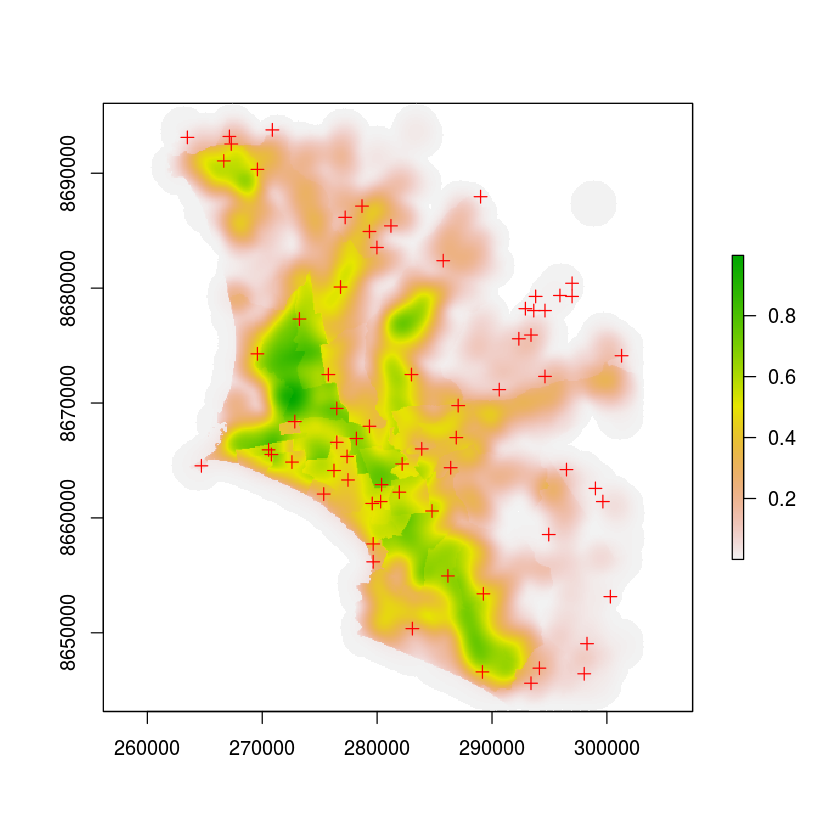

In [23]:
# let us plot the obtained points

#res
#plot(ir_ras)
plot(fm)
#plot(res[[4]],add=TRUE)
doplot<-function(x)
{
    if (!is.null(res[[x]])) plot(SpatialPoints(xyFromCell(ir_ras,res[[x]])),add=TRUE,col='red')
}

a<-sapply(2:length(res),FUN=doplot)